In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error

from baseline.data import MoleculeDatapoint, MoleculeDataset
from baseline.models import FeedForwardNetwork, evaluate, train_one_epoch
from baseline.splits import split_data
from baseline.utils import get_fingerprint, make_rdkit_mol
from baseline.featurizers import MorganFeaturizer

/tmp/ipykernel_600007/537283641.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
path = "/home/hwpang/Projects/BaselineML/data/biogen_solubility.csv"
data_df = pd.read_csv(path)

In [3]:
data_df["mol"] = data_df["SMILES"].apply(make_rdkit_mol)

In [4]:
datapoints = [
    MoleculeDatapoint(
        mol,
        solubility,
        featurizer=MorganFeaturizer(),
    )
    for mol, solubility in zip(data_df["mol"], data_df["logS"])
]

In [5]:
train_dpoints, val_dpoints, test_dpoints = split_data(datapoints)

In [7]:
train_dset = MoleculeDataset(train_dpoints)
val_dset = MoleculeDataset(val_dpoints)
test_dset = MoleculeDataset(test_dpoints)

pca = train_dset.reduce_features(n_components=0.8)
val_dset.reduce_features(pca)
test_dset.reduce_features(pca)

label_scaler = train_dset.normalize_labels()
val_dset.normalize_labels(label_scaler)
test_dset.normalize_labels(label_scaler)


StandardScaler()

In [8]:
n_neighborss = range(1, 30)
train_rmses = np.zeros(len(n_neighborss))
val_rmses = np.zeros(len(n_neighborss))
for i, n_neighbors in enumerate(n_neighborss):
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn.fit(train_dset.features, train_dset.labels)

    train_preds = knn.predict(train_dset.features)
    train_rmse = root_mean_squared_error(train_dset.labels, train_preds)
    train_rmses[i] = train_rmse
    
    val_preds = knn.predict(val_dset.features)
    val_rmse = root_mean_squared_error(val_dset.labels, val_preds)
    val_rmses[i] = val_rmse

best_n_neighbors = n_neighborss[np.argmin(val_rmses)]
print(f"Best number of neighbors: {best_n_neighbors}")

Best number of neighbors: 10


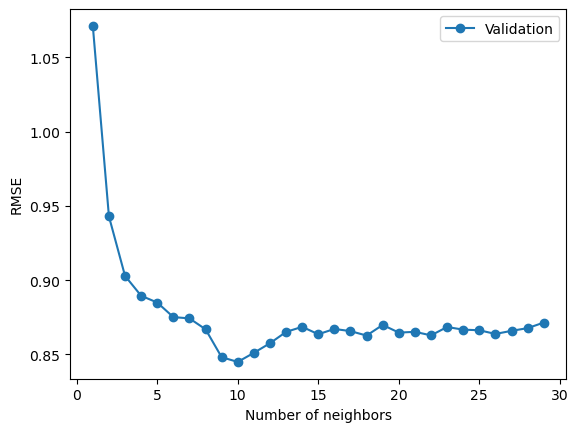

In [9]:
plt.figure()
# plt.plot(n_neighborss, train_rmses, marker="x", label="Train")
plt.plot(n_neighborss, val_rmses, marker="o", label="Validation")
plt.xlabel("Number of neighbors")
plt.ylabel("RMSE")
plt.legend()

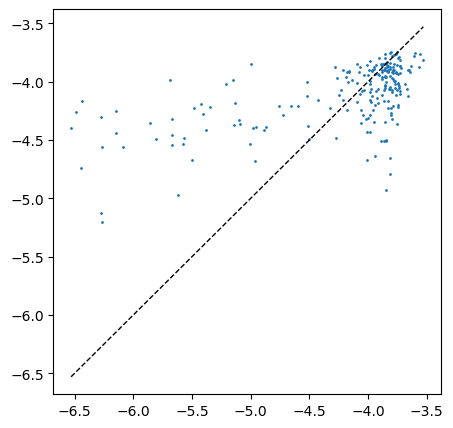

In [10]:
test_preds = knn.predict(test_dset.features)
test_preds = label_scaler.inverse_transform(test_preds)
test_labels = label_scaler.inverse_transform(test_dset.labels)
plt.figure(figsize=(5, 5))
plt.scatter(test_labels, test_preds, s=1)
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], "k--", lw=1)